In [279]:
import os
import cv2
import tensorflow
import keras
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.layers import  Conv2D, MaxPooling2D, Activation, Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

%matplotlib inline

In [ ]:
# Process flow - 
'''
- View on number and size of images in each class
- Read in images
    - Convert to grayscale and resize as required
    - Perform sampling
- Define the CNN structure
- Train, optimize the model
- Test on validation set
    - k-fold
- Predict for test data
'''

In [6]:
# print the working directory
print('Current working directory : ', os.getcwd())

Current working directory :  C:\Users\rohan.nanaware\Documents\Rohan(local)\2 Non-Mu Sigma\HackerEarth


In [7]:
# print the folder names/ list of classes in train folder
data_dir  = os.getcwd()
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')
print('List of classes in train directory : ', os.listdir(train_dir))

List of classes in train directory :  ['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


In [161]:
# list of classes in train directory
list_class_num = os.listdir(train_dir)
list_class_dct = {'0':'Blouse',
				  '1':'Cloak',
				  '2':'Coat',
				  '3':'Jacket',
				  '4':'Jersey',
				  '5':'Long Dress',
				  '6':'Polo Shirt',
				  '7':'Robe',
				  '8':'Shirt',
				  '9':'Short Dress',
				  '10':'Suit',
				  '11':'Sweater',
				  '12':'Undergarment',
				  '13':'Uniform',
				  '14':'Waistcoat'}

try:
    print('Checking if the dictionary was defined properly : ', list_class_dct['11'])
except Exception as e:
    print(e)

Checking if the dictionary was defined properly :  Sweater


In [16]:
# print the numeber of images per training class
for class_num, class_str in list_class_dct.items():
	print('{} images of {} class'.format(len(os.listdir(os.path.join(train_dir, class_num))), class_str))

784 images of Blouse class
6186 images of Cloak class
7936 images of Coat class
8203 images of Jacket class
8835 images of Jersey class
683 images of Long Dress class
5083 images of Polo Shirt class
1248 images of Robe class
3752 images of Shirt class
5301 images of Short Dress class
4560 images of Suit class
1248 images of Sweater class
4848 images of Undergarment class
2935 images of Uniform class
656 images of Waistcoat class


In [18]:
# create a lookup file for the train & test data
train = []
for class_num, class_str in list_class_dct.items():
	for file in os.listdir(os.path.join(train_dir, class_num)):
		train.append(['train/{}/{}'.format(class_num, file), file, class_num, class_str])

train_df = pd.DataFrame(train, columns = ['filepath', 'file', 'class_num', 'class_str'])
print('Size of train data : ', train_df.shape)

test = []
for file in os.listdir(test_dir):
	test.append(['test/{}'.format(file), file])

test_df = pd.DataFrame(test, columns = ['filepath', 'file'])
print('Size of test data : ', test_df.shape)

Size of train data :  (62258, 4)
Size of test data :  (21273, 2)


In [24]:
train_df.head()

,filepath,file,class_num,class_str
0,train/0/n02854926_10038_0.jpg,n02854926_10038_0.jpg,0,Blouse
1,train/0/n02854926_1007_0.jpg,n02854926_1007_0.jpg,0,Blouse
2,train/0/n02854926_10085_0.jpg,n02854926_10085_0.jpg,0,Blouse
3,train/0/n02854926_10122_0.jpg,n02854926_10122_0.jpg,0,Blouse
4,train/0/n02854926_10144_0.jpg,n02854926_10144_0.jpg,0,Blouse


In [25]:
test_df.head()

,filepath,file
0,test/n02667093_10298_0.jpg,n02667093_10298_0.jpg
1,test/n02667093_1089_0.jpg,n02667093_1089_0.jpg
2,test/n02667093_113_0.jpg,n02667093_113_0.jpg
3,test/n02667093_1142_0.jpg,n02667093_1142_0.jpg
4,test/n02667093_1172_0.jpg,n02667093_1172_0.jpg


In [285]:
# function to read images
def read_image(filepath, target_size = None):
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)    
    img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    return img

In [46]:
# sampling train data
class_sample_size = 100 # number of images per class
train_df_sample =  pd.concat([train_df[train_df['class_str'] == class_str][:class_sample_size]for class_num, class_str in list_class_dct.items()])
print('Shape of sample dataframe : {}'.format(train_df_sample.shape))
train_df_sample.groupby('class_str').agg('count')

Shape of sample dataframe : (1500, 6)


,filepath,file,class_num,image_heigth,image_width
class_str,,,,,
Blouse,100,100,100,100,100
Cloak,100,100,100,100,100
Coat,100,100,100,100,100
Jacket,100,100,100,100,100
Jersey,100,100,100,100,100
Long Dress,100,100,100,100,100
Polo Shirt,100,100,100,100,100
Robe,100,100,100,100,100
Shirt,100,100,100,100,100


train/10/n02963159_10017_0.jpg


'10'

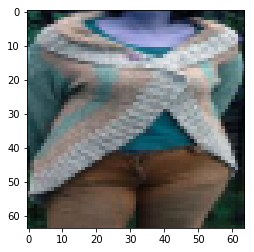

In [287]:
i = 1000
image_resize = (64, 64)
print(train_df_sample.iloc[i].filepath,)
test = cv2.imread(train_df_sample.iloc[i].filepath, cv2.IMREAD_COLOR)
plt.imshow(cv2.resize(test, image_resize, interpolation = cv2.INTER_AREA))
train_df_sample.iloc[i].class_num

In [315]:
## read and preprocess all training/validation/test images and labels
def preprocess_image(img):
    img /= 255.
#     img -= 0.5
#     img *= 2
    return img

target_image_size = 64

x_train_valid = np.zeros((len(train_df_sample), target_image_size, target_image_size, 3),
                         dtype='float32')
y_train_valid = train_df_sample.loc[:, 'class_num'].values

for i, filepath in tqdm(enumerate(train_df_sample['filepath'])):
    
    img = read_image(filepath, (target_image_size, target_image_size))
    x_train_valid[i] = preprocess_image(np.expand_dims(img.copy().astype(np.float), axis=0)) 
    
print('Images read and pre-processed')

1500it [00:04, 315.21it/s]


Images read and pre-processed


In [316]:
print(x_train_valid.shape)
print(y_train_valid.shape)

(1500, 64, 64, 3)
(1500,)


In [354]:
type(x_train_valid)
x_train_valid_gray = np.zeros((len(train_df_sample), target_image_size, target_image_size, 1),
                              dtype='float32')
for i in range(len(x_train_valid)):
    print(x_train_valid[i].shape)
    x_train_valid_gray[i] = cv2.cvtColor(x_train_valid[i], cv2.COLOR_BGR2GRAY).reshape???????

SyntaxError: invalid syntax (<ipython-input-354-5ed062df942d>, line 6)

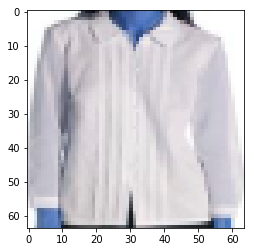

In [350]:
plt.imshow(x_train_valid[1])

(64, 64)


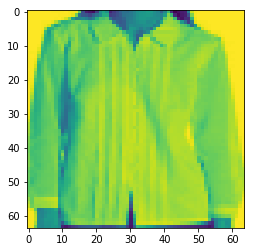

In [353]:
print(cv2.cvtColor(x_train_valid[1], cv2.COLOR_BGR2GRAY).shape)
plt.imshow(cv2.cvtColor(x_train_valid[1], cv2.COLOR_BGR2GRAY))

In [298]:
# split the data into train and validation set
random_seed = 1993
X_train, X_val, Y_train, Y_val = train_test_split(x_train_valid, 
                                                  y_train_valid, 
                                                  test_size = 0.2, 
                                                  random_state = random_seed)

In [250]:
# define model architecture

model = keras.models.Sequential()

model.add(Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu',
                 input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 padding = 'Same',
                 activation = 'relu'))
model.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 padding = 'Same',
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),
                    strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [207]:
keras.__version__

'2.1.5'

In [251]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [252]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<img src = "http://img1.imagilive.com/0717/learningrates.jpg"/>

In [253]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [254]:
epochs = 1 
batch_size = 86

AttributeError: 'list' object has no attribute 'shape'

In [255]:
# data augmentation to prevent overfitting


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (1200, 64, 64)

In [242]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0]
                              , callbacks=[learning_rate_reduction])

NameError: name 'datagen' is not defined